In [10]:
from google.colab import drive
drive.mount('/content/drive')
py_file_location = "/content/drive/MyDrive/Tesis/Git/RedVolcanica"
%cd "{py_file_location}" 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Tesis/Git/RedVolcanica


In [32]:
import importlib

import RedFunciones.visualizacion as visualizacion
import RedFunciones.Generador as Generador
import RedFunciones.Discriminador as Discriminador
import RedFunciones.auxiliares as auxiliares
import RedFunciones.DataloaderVol as DataloaderVol

importlib.reload(auxiliares)
importlib.reload(Generador)
importlib.reload(DataloaderVol)

<module 'RedFunciones.DataloaderVol' from '/content/drive/MyDrive/Tesis/Git/RedVolcanica/RedFunciones/DataloaderVol.py'>

In [33]:
import torch
from torch import nn

from tqdm.auto import tqdm # Progress bar

from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import MNIST #noned

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

torch.manual_seed(0) # Set for our testing purposes, please do not change!



criterion: the loss function

n_epochs: the number of times you iterate through the entire 
dataset when training

z_dim: the dimension of the noise vector

display_step: how often to display/visualize the images

batch_size: the number of images per forward/backward pass

lr: the learning rate

device: the device type

In [34]:
mnist_shape = (1, 129, 33) #tamaño imagen
n_classes = 2 # numkero etiquetas
cuda0 = torch.device('cuda:0')

criterion = nn.BCEWithLogitsLoss()
n_epochs = 2
z_dim = 64
display_step = 500
batch_size = 30
lr = 0.0002
#device = cuda0
device = 'cpu'

In [35]:
# transform talves a funcion
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

#cargar datos
dir_nam = '/content/drive/MyDrive/Tesis/Red/basedesglosada/'
json_nam = '/content/drive/MyDrive/Tesis/Red/data.json'
h5_filename = '/content/drive/MyDrive/Tesis/Git/RedVolcanica/baseh5/data1.h5'

myData = DataloaderVol.VolcanoDatasetH5(h5_filename)

dataloader = DataLoader(
    myData,
    batch_size=batch_size,
    shuffle=True)

# New Section

In [69]:
generator_input_dim, discriminator_im_chan = auxiliares.get_input_dimensions(z_dim, mnist_shape, n_classes)

gen = Generador.Generator(input_dim=generator_input_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminador.Discriminator(im_chan=discriminator_im_chan).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

gen = gen.apply(auxiliares.weights_init)
disc = disc.apply(auxiliares.weights_init)

  0%|          | 0/677 [00:00<?, ?it/s]

Congratulations! If you've gotten here, it's working. Please let this train until you're happy with how the generated numbers look, and then go on to the exploration!
Step 500: Generator loss: nan, discriminator loss: nan


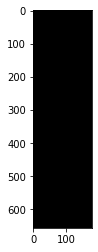

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


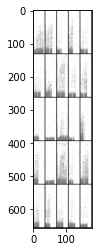

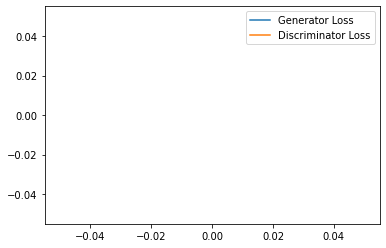

  0%|          | 0/677 [00:00<?, ?it/s]

Step 1000: Generator loss: nan, discriminator loss: nan


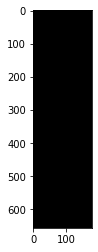

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


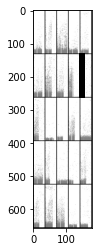

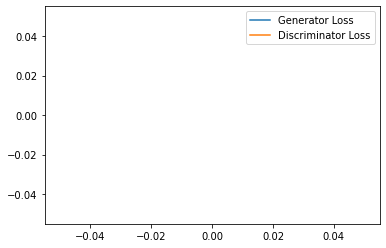

In [37]:
cur_step = 0
generator_losses = []
discriminator_losses = []

#UNIT TEST NOTE: Initializations needed for grading
noise_and_labels = False
fake = False

fake_image_and_labels = False
real_image_and_labels = False
disc_fake_pred = False
disc_real_pred = False

for epoch in range(n_epochs): 
    # Dataloader returns the batches and the labels
    for real, labels in tqdm(dataloader):
        cur_batch_size = len(real)
        # Flatten the batch of real images from the dataset
        real = real.unsqueeze(1)
        real = real.to(device)

        one_hot_labels = auxiliares.get_one_hot_labels(labels.to(device), n_classes)
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = image_one_hot_labels.repeat(1, 1, mnist_shape[1], mnist_shape[2])

        ### Update discriminator ###
        # Zero out the discriminator gradients
        disc_opt.zero_grad()
        # Get noise corresponding to the current batch_size 
        fake_noise = auxiliares.get_noise(cur_batch_size, z_dim, device=device)
        
        # Now you can get the images from the generator
        # Steps: 1) Combine the noise vectors and the one-hot labels for the generator
        #        2) Generate the conditioned fake images
       
        noise_and_labels = auxiliares.combine_vectors(fake_noise, one_hot_labels)
        fake = gen(noise_and_labels)#gen.forward(noise_and_labels) no usar

        # Now you can get the predictions from the discriminator
        # Steps: 1) Create the input for the discriminator
        #           a) Combine the fake images with image_one_hot_labels, 
        #              remember to detach the generator (.detach()) so you do not backpropagate through it
        #           b) Combine the real images with image_one_hot_labels
        #        2) Get the discriminator's prediction on the fakes as disc_fake_pred
        #        3) Get the discriminator's prediction on the reals as disc_real_pred
        
        fake_image_and_labels = auxiliares.combine_vectors(fake.detach(), image_one_hot_labels)
        real_image_and_labels = auxiliares.combine_vectors(real, image_one_hot_labels)
        disc_fake_pred = disc(fake_image_and_labels)
        disc_real_pred = disc(real_image_and_labels)       
        
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2
        disc_loss.backward(retain_graph=True)
        disc_opt.step() 

        # Keep track of the average discriminator loss
        discriminator_losses += [disc_loss.item()]

        ### Update generator ###
        # Zero out the generator gradients
        gen_opt.zero_grad()

        fake_image_and_labels = auxiliares.combine_vectors(fake, image_one_hot_labels)
        # This will error if you didn't concatenate your labels to your image correctly
        disc_fake_pred = disc(fake_image_and_labels)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the generator losses
        generator_losses += [gen_loss.item()]
        #

        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            disc_mean = sum(discriminator_losses[-display_step:]) / display_step
            print(f"Step {cur_step}: Generator loss: {gen_mean}, discriminator loss: {disc_mean}")
            visualizacion.show_tensor_images(fake)
            visualizacion.show_tensor_images(real)
            step_bins = 20
            x_axis = sorted([i * step_bins for i in range(len(generator_losses) // step_bins)] * step_bins)
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(discriminator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Discriminator Loss"
            )
            plt.legend()
            plt.show()
        elif cur_step == 0:
            print("Congratulations! If you've gotten here, it's working. Please let this train until you're happy with how the generated numbers look, and then go on to the exploration!")
        cur_step += 1

In [79]:
print(gen)

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(66, 256, kernel_size=(5, 3), stride=(2, 2))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(6, 4), stride=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(6, 4), stride=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(64, 32, kernel_size=(6, 4), stride=(2, 2))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Sequential(
      (0): ConvTranspose2d(32, 1, kernel_size=(27, 4), stride=(2, 1))

In [103]:
gen_opt.state_dict()

OrderedDict()

In [104]:
from torchvision import models
from torchsummary import summary

summary(gen, (66,1,1))

summary(disc, (3,129,33))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 5, 3]         253,696
       BatchNorm2d-2            [-1, 256, 5, 3]             512
              ReLU-3            [-1, 256, 5, 3]               0
   ConvTranspose2d-4           [-1, 128, 10, 6]         786,560
       BatchNorm2d-5           [-1, 128, 10, 6]             256
              ReLU-6           [-1, 128, 10, 6]               0
   ConvTranspose2d-7           [-1, 64, 24, 14]         196,672
       BatchNorm2d-8           [-1, 64, 24, 14]             128
              ReLU-9           [-1, 64, 24, 14]               0
  ConvTranspose2d-10           [-1, 32, 52, 30]          49,184
      BatchNorm2d-11           [-1, 32, 52, 30]              64
             ReLU-12           [-1, 32, 52, 30]               0
  ConvTranspose2d-13           [-1, 1, 129, 33]           3,457
             Tanh-14           [-1, 1, 